In [1]:
%matplotlib widget

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
from pathlib import Path

In [6]:
from typing import List

In [7]:
from typing import Tuple

In [8]:
from copy import deepcopy

In [9]:
import json

In [10]:
name : str = "lightspeed0"

In [11]:
data = pd.read_csv(Path(name) / (name + ".csv"))

In [12]:
spaceStep = data[name + "0::SpaceStep"][0]

In [13]:
timeStep = data[name + "0::TimeStep"][0]

In [14]:
tolerence = spaceStep ** 2

In [15]:
frameCount = len(data[name + "0::SpaceStep"])

In [16]:
count = 1

In [17]:
controlIndex = 0

In [18]:
regionProbabilities : List[List[np.array]] = []
regionNames : List[str] = ["Post", "3rdStair", "2ndStair", "1stStair", "Pre"]
regionIndex : int = 0
for regionName in regionNames: 
    regionProbabilities.append([])
    for ii in range(count): 
         regionProbabilities[regionIndex].append(data[name + str(ii) + "::Probabilities::" + regionName])
    regionIndex += 1

In [19]:
regionLengths : List[float] = []
for regionName in regionNames: 
    regionLengths.append(data[name + str(controlIndex) + "::RegionLength::" + regionName][0])

In [20]:
regionLengths

[0.3, 0.1333333333333333, 0.1333333333333333, 0.1333333333333333, 0.3]

In [21]:
def makeColors(colorCount : int) -> List[Tuple[float, float, float, float]]:
    colors : List[Tuple[int, int, int, int]] = []
    chunkPerComponent : int = round(colorCount / 3) + 1
    currentColor : List[int, int, int, int] = [0.0, 0.0, 0.0, 255]
    colorStep : int = round(255 / (chunkPerComponent + 1))
    for ii in range(chunkPerComponent): 
        for jj in range(3): 
            currentColor[jj] += colorStep
            a = currentColor[(jj + 1) % 3]
            currentColor[(jj + 2) % 3] = np.sqrt(np.abs((currentColor[jj] ** 2) - a ** 2))
            colors.append(np.array(currentColor) / 255)
    return colors

In [22]:
def displayRegion(probabilities : List[np.array], regionName : str, excludeList : List[int] = [], customColors = False): 
    plt.figure()
    legendLabels = []
    ii = 0
    colors : List[Tuple[float, float, float, float]] = makeColors(len(probabilities))
    #colors = np.arange(len(probabilities)) / len(probabilities)
    for probabilitySet in probabilities: 
        if ii in excludeList: 
            ii += 1
            continue
        if customColors == True: 
            plt.plot(np.arange(len(probabilitySet)), probabilitySet, color = colors[ii])
        else: 
            plt.plot(np.arange(len(probabilitySet)), probabilitySet)
        legendLabels.append(regionName + str(ii))
        ii += 1
    plt.title(name)
    plt.legend(legendLabels)

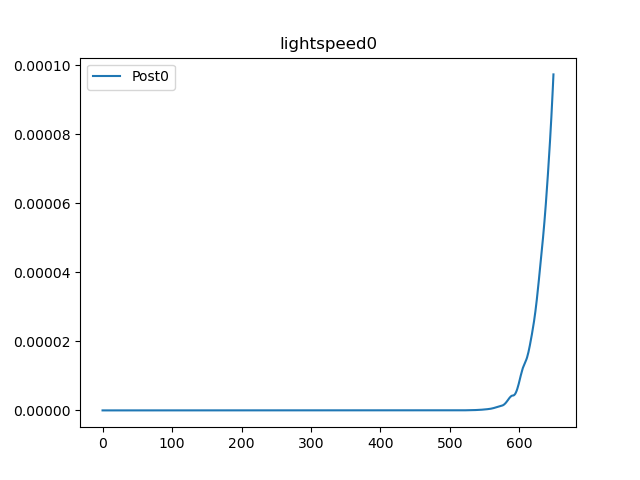

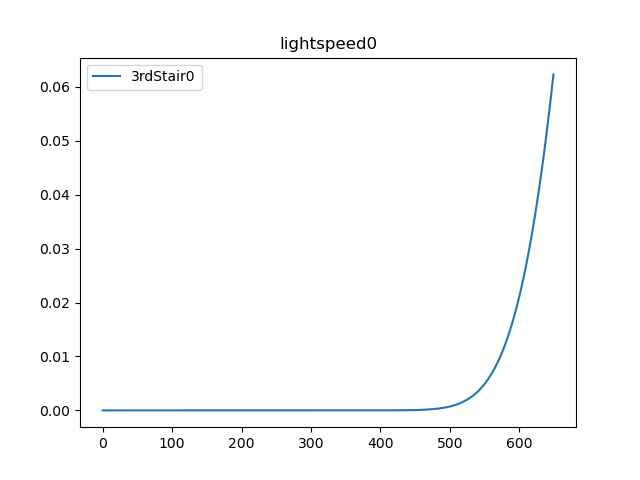

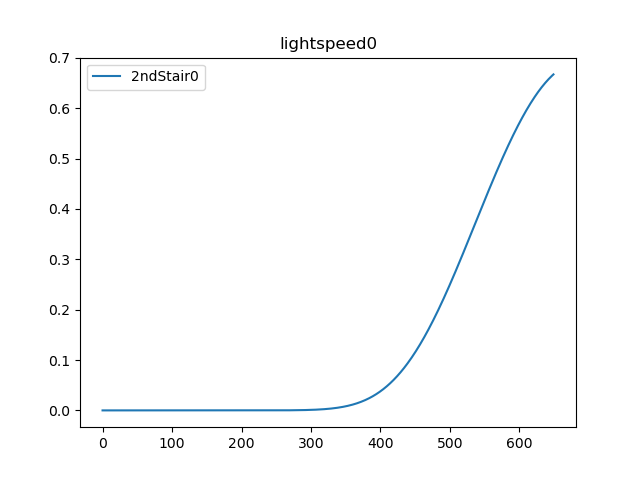

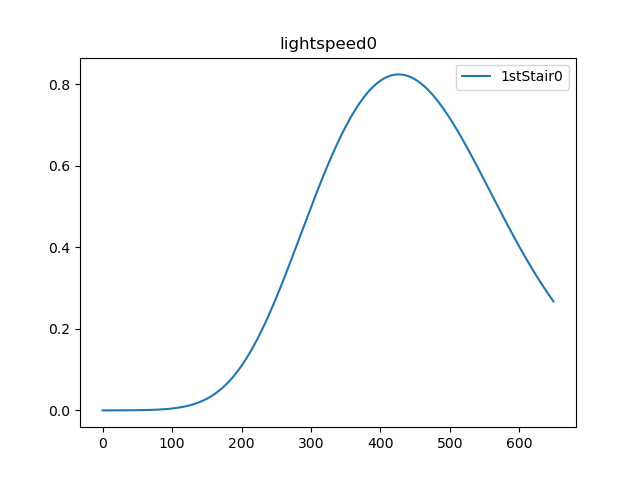

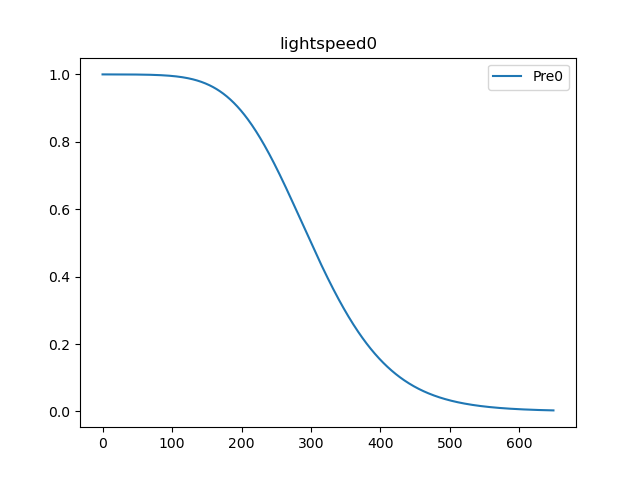

In [23]:
for ii in range(len(regionProbabilities)): 
    displayRegion(regionProbabilities[ii], regionNames[ii])#, [1, 2, 4, 15, 13, 8, 9])

In [27]:
regionIndicies = np.arange(len(regionLengths))[1:]

In [28]:
def limitLines(tolerence, waveIndex): 
    tolerenceSuperluminalLimits = []
    for regionIndex in regionIndicies:
        w = np.where(regionProbabilities[regionIndex][waveIndex] >= tolerence)
        tolerenceSuperluminalLimits.append(w[0][0])
    return tolerenceSuperluminalLimits 

In [29]:
arrivalTimes = limitLines(tolerence, 0)

In [30]:
regionLengths

[0.3, 0.1333333333333333, 0.1333333333333333, 0.1333333333333333, 0.3]

In [31]:
arrivalTimes

[459, 256, 20, 0]

In [32]:
packetStartX = data["packetStartX"][0]

In [33]:
standardDeviation = data["standardDeviation"][0]

In [34]:
print(packetStartX)

0.85


In [35]:
print(regionLengths)

[0.3, 0.1333333333333333, 0.1333333333333333, 0.1333333333333333, 0.3]


In [48]:
totalLengths = [0]
ii = 0
for regionLength in regionLengths[1:-1]: 
    l = regionLength
    if ii == 0: 
        l = packetStartX#regionLength - (1 - packetStartX)# - standardDeviation
        ii += 1
    totalLengths.append(totalLengths[-1] + l)
totalLengths = totalLengths[1:]
totalLengths.reverse()
totalLengths = np.array(totalLengths) * spaceStep
times = np.array(arrivalTimes[:-1]) * timeStep
speeds = (totalLengths / times)

In [49]:
totalLengths

array([0.01116667, 0.00983333, 0.0085    ])

In [50]:
times

array([0.011475, 0.0064  , 0.0005  ])

In [51]:
times[0] - times[1]

0.0050750000000000005

In [52]:
times[1] - times[2]

0.005900000000000001

In [53]:
times[2] - times[3]

IndexError: index 3 is out of bounds for axis 0 with size 3

In [54]:
speeds

array([ 0.97312999,  1.53645833, 17.        ])

In [55]:
speeds[0] - speeds[1]

-0.5633283405954974

In [56]:
speeds[1] - speeds[2]

-15.463541666666666

In [57]:
speeds[2] - speeds[3]

IndexError: index 3 is out of bounds for axis 0 with size 3

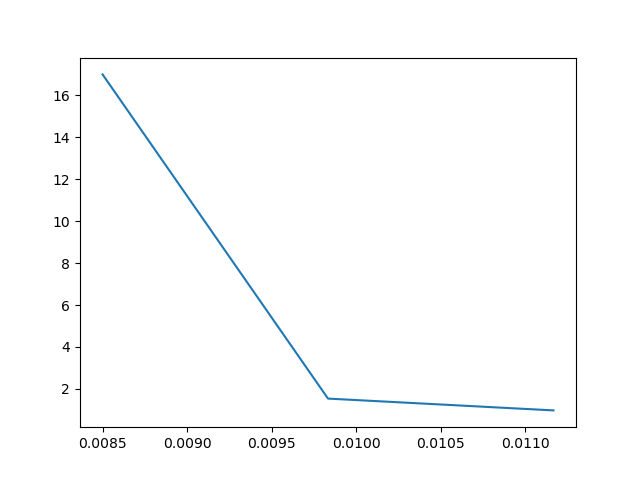

In [58]:
plt.close()
plt.figure()
plt.plot(totalLengths, speeds)

In [59]:
with open(str(Path.cwd() / name / "controlProfile.json"), "w") as jsonFile:
    jsonString = json.dumps({
            "timeStep" : timeStep, 
            "spaceStep" : spaceStep, 
            "regionLengths" : [float(regionLength) for regionLength in regionLengths], 
            "arrivalTimes" : [int(time) for time in arrivalTimes], 
            "speeds" : [float(speed) for speed in speeds]
        })
    jsonFile.write(jsonString)